# Analysis of the best model

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Custom functions
from sample_panel.merge_datasets import merge_bank_macro_datasets
from supervised_learning.cross_validation import PanelDataSplit
from supervised_learning.sensitivity_analysis import outliers_sensitivity
from supervised_learning.cross_validation import ablation_analysis
from supervised_learning.estimate_errors import estimate_errors

## Loading data

In [3]:
# Load bank panel data
bank_data = pd.read_csv('df_response_vars.csv')

In [4]:
# Load macroeconomic data
macro_data = pd.read_csv('macro_features.csv')
macro_columns = macro_data.columns

# Factors with lags are not used in the model. Remove factors with lags
new_macro_columns = [col for col in macro_columns if '_lag' not in col]
macro_data = macro_data[new_macro_columns]

In [5]:
# Load PCA components
pca_data = pd.read_csv('macro_pca_df.csv')

In [6]:
# Load additional macro variables
macro_data1 = pd.read_csv('macro_most_inf_df.csv')
# Clean column names
macro_data1.columns = [col.replace('\n', ' ') for col in macro_data1.columns]

In [7]:
# Merge the bank panel and macroeconomic indicators
data_set = merge_bank_macro_datasets(bank_data, macro_data, pca_data, macro_data1)

In [8]:
# Delete Nans values due to the lag of the response variable
data_set.dropna(subset=['Provision_Lag1'], inplace=True)
data_set.reset_index(drop=True, inplace=True)

## Chosen model

In [9]:
# Response variable
y_col = 'Provision for Loan Lease Losses as % of Aver. Assets'

In [10]:
# Features
features = ['Provision_Lag1', 'Real GDP growth_ema3', 'Dow Jones Total Stock Market Index change']

In [11]:
# Fixed Effects (individual intercept for each bank)
data_set['IDRSSD1'] = data_set['IDRSSD']
data_set = pd.get_dummies(data_set, columns=['IDRSSD1'], drop_first=True)
fixed_effects_features = [col for col in data_set.columns if col.startswith('IDRSSD1_')]

In [12]:
# Full set of features
features_all = features + fixed_effects_features

In [13]:
scaler = StandardScaler()
gb_model = GradientBoostingRegressor(random_state=42)

best_model = Pipeline(steps=[("scaler", scaler), ("gb_model", gb_model)])

## Train Test Split

In [14]:
data_set_train_full = data_set[data_set['Report Date']<='2021-12-31'].copy()
data_set_test = data_set[data_set['Report Date']>'2021-12-31'].copy()

## Outliers

### Removing outliers from the train set

In [15]:
lower_limit = np.percentile(data_set_train_full[y_col], 0.5)
upper_limit = np.percentile(data_set_train_full[y_col], 99)

data_set_train = data_set_train_full.copy()[(data_set_train_full[y_col]<=upper_limit)&(data_set_train_full[y_col]>=lower_limit)]
data_set_train.reset_index(drop=True, inplace=True)

In [16]:
X_train = data_set_train_full[features_all]
y_train = data_set_train_full[y_col]

## Model trained on the train set

In [17]:
X_train = data_set_train[features_all]
y_train = data_set_train[y_col]
best_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gb_model', GradientBoostingRegressor(random_state=42))])

### Performance on the train set

In [18]:
y_pred = best_model.predict(X_train)
estimate_errors(y_train, y_pred)

,measure
R squared,0.88275
RMSE,0.297434
"median relative error, %",17.976709


### Performance on the test set

In [19]:
X_test = data_set_test[features_all]
y_test = data_set_test[y_col]
y_pred = best_model.predict(X_test)
# Excluding points, there were identified as outliers on the train set
estimate_errors(y_test, y_pred, lower_limit, upper_limit)

,measure
R squared,0.821973
RMSE,0.221627
"median relative error, %",40.290357


## Feature importance
### Ablation analysis

In [20]:
# Define sets of features by excluding factors of group of factors
features_sets = {
    'Complete features set': features_all, 
    'Omitting Provision_lag1': ['Real GDP growth_ema3', 'Dow Jones Total Stock Market Index change'] + fixed_effects_features,
    'Omitting Fixed effects': features, 
    'Omitting Dow Jones Index change': ['Provision_Lag1', 'Real GDP growth_ema3'] + fixed_effects_features, 
    'Omitting Real GDP growth_ema3': ['Provision_Lag1', 'Dow Jones Total Stock Market Index change'] + fixed_effects_features,
}

In [21]:
panel_cv = PanelDataSplit(test_size=4, date_axis=data_set_train['Report Date'], n_splits=10)

In [22]:
# Run ablation analysis by calculating cross-validation scores for specified sets of features "features_sets"
ablation_res = ablation_analysis(best_model, data_set_train,
                                 features_sets, y_col, panel_cv)
ablation_res

,R^2 mean,R^2 standard error of the mean
Complete features set,0.769693,0.092081
Omitting Provision_lag1,0.232723,0.217550
Omitting Fixed effects,0.738240,0.116270
Omitting Dow Jones Index change,0.755240,0.103244
Omitting Real GDP growth_ema3,0.767142,0.092016


## Sensitivity analysis
We've decided to conduct a sensitivity analysis to gain insights into how approach to defining outliers impacts the accuracy of our model. This is due to the presence of numerous outliers in our response variable, "Provision for Loan Lease Losses". Generally, outliers have a negative impact because in datasets containing outliers, the estimator becomes biased in favor of these extreme values. Consequently, this results in a decrease in the model's accuracy for typical data points.

In our sensitivity analysis, we assessed the model's performance under various outlier specifications. These different scenarios are detailed in the "train_limits" list. For instance, "train_limit=(1, 98)" means that in the training sample, all data points below the 1st percentile and above the 98th percentile are excluded. The variant "(0, 100)" means that the entire training sample is retained, without excluding any outliers.

In our analysis of the test sample, we also incorporated an outlier specification, as it is crucial to understand how our decisions regarding outlier handling in the train sample influence different types of data points within the test set. "test_limits=(1, 91)" means that, for the test sample, we categorize typical data points as falling between the 1st and 91st percentiles, while any data points beyond this range are classified as outliers. We are examining how our choice of outlier specification (defined in "train_limits") impacts model accuracy for typical data points and for outliers in the test set.

These outlier specifications are driven by the observation that the distribution of the response variable is right-skewed, with a greater concentration of outliers towards the right end of the distribution compared to the left end.

In [23]:
train_limits = [(0, 100), (1, 98), (1, 96), (1, 94), (1, 92), (1, 90), ]
test_limits = (1, 91)

# Number of splits for cross-validation
fold_num=5

In [24]:
sensitivity_to_outliers = outliers_sensitivity(data_set_train_full, data_set_test, features_all, y_col,
                                               best_model, fold_num,
                                               train_limits, test_limits)
sensitivity_to_outliers

,excluded outliers from train set,train set size (excl.outliers),train cross-validation RMSE (excl. outliers),test size (excl. points that were considered outliers in train),test RMSE (excl. points that were considered outliers in train),"test RMSE for all points, samplesize=716","test RMSE for typical points (between 1 and 91 percentiles in test set), samplesize=640","test RMSE for outliers (lowest 1% or highest 9% in test set), samplesize=76"
0,"(0, 100)",15664,0.410311,716,0.356724,0.356724,0.122979,1.070285
1,"(1, 98)",15196,0.240833,705,0.215186,0.454678,0.099839,1.411492
2,"(1, 96)",14883,0.225469,701,0.211656,0.544317,0.096885,1.703169
3,"(1, 94)",14572,0.197383,697,0.188851,0.608993,0.091213,1.913864
4,"(1, 92)",14259,0.180773,692,0.170747,0.647008,0.091163,2.035862
5,"(1, 90)",13943,0.166751,686,0.134579,0.675879,0.085617,2.130377


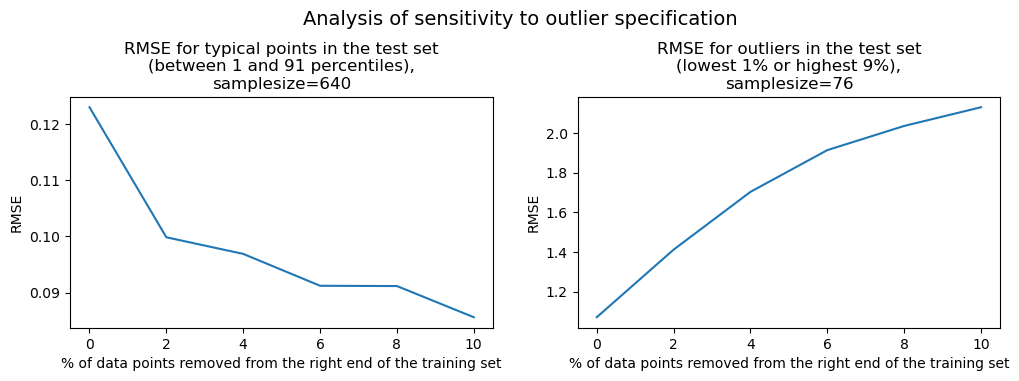

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

x_labels = [100-x[1] for x in train_limits]

ax1.plot(x_labels, sensitivity_to_outliers.iloc[:, 6])
ax2.plot(x_labels, sensitivity_to_outliers.iloc[:, 7])

ax1.set_title('RMSE for typical points in the test set\n(between 1 and 91 percentiles),\nsamplesize=640')
ax2.set_title('RMSE for outliers in the test set\n(lowest 1% or highest 9%),\nsamplesize=76')

ax1.set(xlabel='% of data points removed from the right end of the training set', ylabel='RMSE')
ax2.set(xlabel='% of data points removed from the right end of the training set', ylabel='RMSE')

fig.suptitle('Analysis of sensitivity to outlier specification', fontsize=14, y=1.17);

This image illustrates the adverse impact of having outliers in the training dataset on the model's accuracy for typical data points. When no outliers are removed from the training set, the root mean square error (RMSE) for the majority of data points in the test sample (90% of the test sample) is 0.123. However, if we exclude 10% of the data points from the right end of the training distribution, the RMSE for the majority of data points decreases to 0.086. Excluding outliers results in a less biased estimator and improved performance for typical data points. Nonetheless, the exclusion of data points leads to less accurate predictions for the outliers within the test sample (10% of the test sample).

## Failure analysis
Creating the Excel file for the purpose of error analysis.

In [26]:
# Get predictions for the whole data set (train + test)
best_model.fit(X_train, y_train)
data_set['y_pred'] = best_model.predict(data_set[features_all])
data_set['squared error'] = (data_set[y_col] - data_set['y_pred'])**2

In [27]:
columns_to_load = ['Report Date', 'IDRSSD', 'Financial Institution Name', y_col, 'y_pred', 'squared error'] + features
data_set[columns_to_load].to_excel('failure_analysis.xlsx')